In [1]:
import fileinput
from typing import List
from torch import tensor, FloatTensor
import torch

aspects: List[float] = []

# https://huggingface.co/datasets/Birchlabs/danbooru-aspect-ratios/resolve/main/danbooru-aspect-ratios.csv
with fileinput.input(files=('/home/birch/ml-data/danbooru-aspect-ratios.csv'), encoding='ascii') as f:
  # skip header line
  next(f)
  for line in f:
    aspect = float(line.rstrip('\n'))
    aspects.append(aspect)

device = torch.device('cuda')

a: FloatTensor = tensor(aspects, dtype=torch.float32, device=device)

used 32 iterations (0.444s) to cluster 6378288 items into 20 clusters
top 20 angles (º):
tensor([ 9.1464, 18.2462, 22.4912, 26.1364, 28.8630, 30.4583, 31.7490, 32.7561,
        33.6264, 34.2871, 34.9975, 35.4093, 37.0419, 39.2707, 42.1349, 45.5603,
        51.7980, 54.8702, 58.1523, 62.2992], device='cuda:0')
top 20 aspect ratios:
tensor([0.1610, 0.3297, 0.4140, 0.4907, 0.5512, 0.5881, 0.6188, 0.6434, 0.6651,
        0.6818, 0.7001, 0.7109, 0.7547, 0.8176, 0.9047, 1.0198, 1.2707, 1.4213,
        1.6098, 1.9047], device='cuda:0')


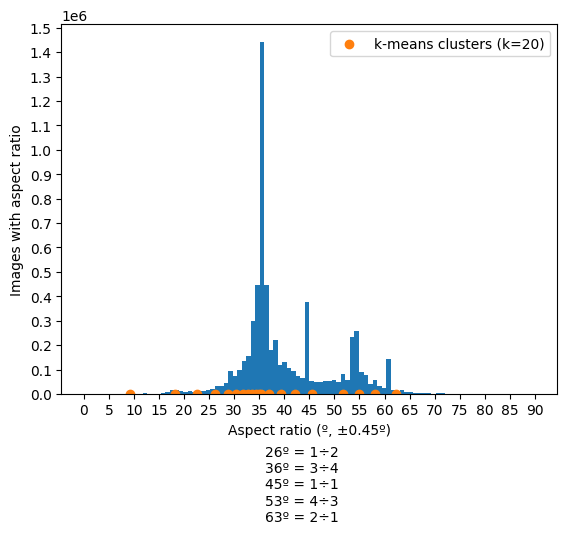

In [131]:
from kmeans_pytorch import kmeans
from fast_pytorch_kmeans import KMeans
from torch import randn, Generator, histc, linspace, zeros_like
import matplotlib.pyplot as plt
import math

gen = Generator(device=device).manual_seed(1234)
# samp: FloatTensor = randn(100, dtype=torch.float32, device=device, generator=gen)
# samp = a#[:1000]
samp = (180/math.pi*a.atan())

bin_min, bin_max = samp.min(), samp.max()
bin_count = 100
bin_occupants: FloatTensor = histc(samp, bins = bin_count)
bins: FloatTensor = linspace(start=bin_min, end=bin_max, steps=bin_count, device=device)
bin_step: FloatTensor = (bin_max-bin_min)/(bin_count-1)
bin_half_step: FloatTensor = bin_step / 2
bin_mids: FloatTensor = bins + bin_half_step

n_clusters = 20
# cluster_ids_x, cluster_centers = kmeans(
#   X=samp.unsqueeze(-1), num_clusters=n_clusters, distance='euclidean', device=device
# )
kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=1, max_iter=5000)
kmeans.fit_predict(samp.unsqueeze(-1))
cluster_centers: FloatTensor = kmeans.centroids

plt.bar(x=bins.cpu(), height=bin_occupants.cpu(), width=bin_step.cpu())
plt.scatter(cluster_centers.cpu(), zeros_like(cluster_centers, device='cpu'), label=f'k-means clusters (k={n_clusters})')
plt.legend()
plt.xlabel(f'Aspect ratio (º, ±{bin_half_step.item():.2f}º)')
plt.locator_params(nbins=20)
plt.ylabel('Images with aspect ratio')
expl = '''26º = 1÷2
36º = 3÷4
45º = 1÷1
53º = 4÷3
63º = 2÷1'''
plt.figtext(0.5, -0.15, expl, wrap=True, horizontalalignment='center', fontsize=10)
cluster_centers, _ = cluster_centers.squeeze().sort()
clusters_radians: FloatTensor = math.pi/180*cluster_centers
clusters_ratios: FloatTensor = clusters_radians.tan()

print(f'top 20 angles (º):\n{cluster_centers}')
print(f'top 20 aspect ratios:\n{clusters_ratios}')

In [133]:
from torch import IntTensor

for side_len in (512,):#, 1024):
  thetas_sin: FloatTensor = clusters_radians.sin()
  thetas_cos: FloatTensor = clusters_radians.cos()

  hypotenuses: FloatTensor = side_len/(2*thetas_sin*thetas_cos)**.5

  heights: FloatTensor = hypotenuses*2**.5*thetas_sin
  widths: FloatTensor = hypotenuses*2**.5*thetas_cos

  buckets = torch.column_stack([widths, heights])
  buckets_rounded: IntTensor = 8*(buckets / 8).round().int()

  print(f'bucket sizes with area approx {side_len}*{side_len}:\n{buckets_rounded}')

bucket sizes with area approx 512*512:
tensor([[1280,  208],
        [ 888,  296],
        [ 792,  328],
        [ 728,  360],
        [ 688,  384],
        [ 664,  392],
        [ 648,  400],
        [ 640,  408],
        [ 624,  416],
        [ 624,  424],
        [ 608,  432],
        [ 608,  432],
        [ 592,  448],
        [ 568,  464],
        [ 536,  488],
        [ 504,  520],
        [ 456,  576],
        [ 432,  608],
        [ 400,  648],
        [ 368,  704]], device='cuda:0', dtype=torch.int32)
